# Data Collection

## Combining dataset
Do yêu cầu dataset phải có tối thiểu 1000 dòng $\rightarrow$ nhóm quyết định gộp 2 file `.csv` trong tập dataset **Student Alcohol Consumption** gồm `student-mat.csv` và `student-por.csv` (2 file đều có chung các thuộc tính) thành `student-combine.csv` (có thêm thuộc tính `subject` cho `mat` và `por`) để xử lý cho các bước kế tiếp

In [1]:
import pandas as pd

df_mat = pd.read_csv("../data/raw/student-mat.csv")
df_por = pd.read_csv("../data/raw/student-por.csv")

In [2]:
# Thêm giá trị cho thuộc tính subject
df_mat['subject'] = 'mat'
df_por['subject'] = 'por'

In [3]:
# Gộp 2 data frame
df_combine = pd.concat([df_mat, df_por], axis=0, ignore_index=True)

df_combine.to_csv("../data/raw/student-combine.csv", index=False)

## Why choose this dataset?
- Nhóm chọn dataset **Student Alcohol Consumption** vì tính thực tiễn và dữ liệu đa dạng. Dataset giúp người đọc có một cái nhìn khách quan về các yếu tố tác động, từ môi trường đến hoạt động hàng ngày, có ảnh hưởng như thế nào đến hành vi tiêu thụ cồn. Từ đó, nhóm có thể phân tích và đánh giá tác động thực tế của lối sống lên hiệu suất học tập (môn toán và môn tiếng Bồ Đào Nha) của học sinh trung học.

- Một số câu hỏi và insight tiềm năng có thể tìm thấy ở dataset này:
    1. Câu hỏi về hiệu suất học tập: mức độ tiêu thụ cồn (hàng ngày và cuối tuần) có mối liên hệ như thế nào đến kết quả học tập hay không?

    2. Câu hỏi về môi trường và xã hội: liệu học sinh dành nhiều thời gian đi chơi, hay ở trong một mối quan hệ tình cảm thường sẽ tiêu thụ cồn nhiều hơn hay không?

    3. Câu hỏi về gia đình: trình độ học vấn của ba, mẹ và sự ổn định trong gia đình có ảnh hưởng đến hành vi uống rượu của con cái hay không?

    4. Câu hỏi về sức khoẻ, đi học: tình trạng sức khoẻ hay số ngày nghỉ học có phản ánh sớm việc sa sút trong học tập?

# Data Exploration

## Categorical Columns Analysis

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import math

In [5]:
df = pd.read_csv("../data/raw/student-combine.csv")

In [6]:
cat_cols = df.select_dtypes(include=['object']).columns
print(f"Categorical colums: {cat_cols}")

Categorical colums: Index(['school', 'sex', 'address', 'famsize', 'Pstatus', 'Mjob', 'Fjob',
       'reason', 'guardian', 'schoolsup', 'famsup', 'paid', 'activities',
       'nursery', 'higher', 'internet', 'romantic', 'subject'],
      dtype='object')


### Value Distribution

In [7]:
def analyze_cat_col(colname, df):
    print(f"\nCategorical column: {colname.upper()}")

    unique_count = df[colname].nunique()
    print(f"- Unique value: {unique_count}")
    
    val_counts = df[colname].value_counts()
    top_5 = val_counts.head(5)
    
    print(f"- Top 5 most frequent value:\n {top_5}")
    
    print(f"- Percentage distribution:")
    distributions = df[colname].value_counts(normalize= True) * 100
    for uni, val in distributions.items():
        print(f"{uni} : {val:.2f}%")

In [8]:
for col in cat_cols:
    analyze_cat_col(col, df)


Categorical column: SCHOOL
- Unique value: 2
- Top 5 most frequent value:
 school
GP    772
MS    272
Name: count, dtype: int64
- Percentage distribution:
GP : 73.95%
MS : 26.05%

Categorical column: SEX
- Unique value: 2
- Top 5 most frequent value:
 sex
F    591
M    453
Name: count, dtype: int64
- Percentage distribution:
F : 56.61%
M : 43.39%

Categorical column: ADDRESS
- Unique value: 2
- Top 5 most frequent value:
 address
U    759
R    285
Name: count, dtype: int64
- Percentage distribution:
U : 72.70%
R : 27.30%

Categorical column: FAMSIZE
- Unique value: 2
- Top 5 most frequent value:
 famsize
GT3    738
LE3    306
Name: count, dtype: int64
- Percentage distribution:
GT3 : 70.69%
LE3 : 29.31%

Categorical column: PSTATUS
- Unique value: 2
- Top 5 most frequent value:
 Pstatus
T    923
A    121
Name: count, dtype: int64
- Percentage distribution:
T : 88.41%
A : 11.59%

Categorical column: MJOB
- Unique value: 5
- Top 5 most frequent value:
 Mjob
other       399
services    2

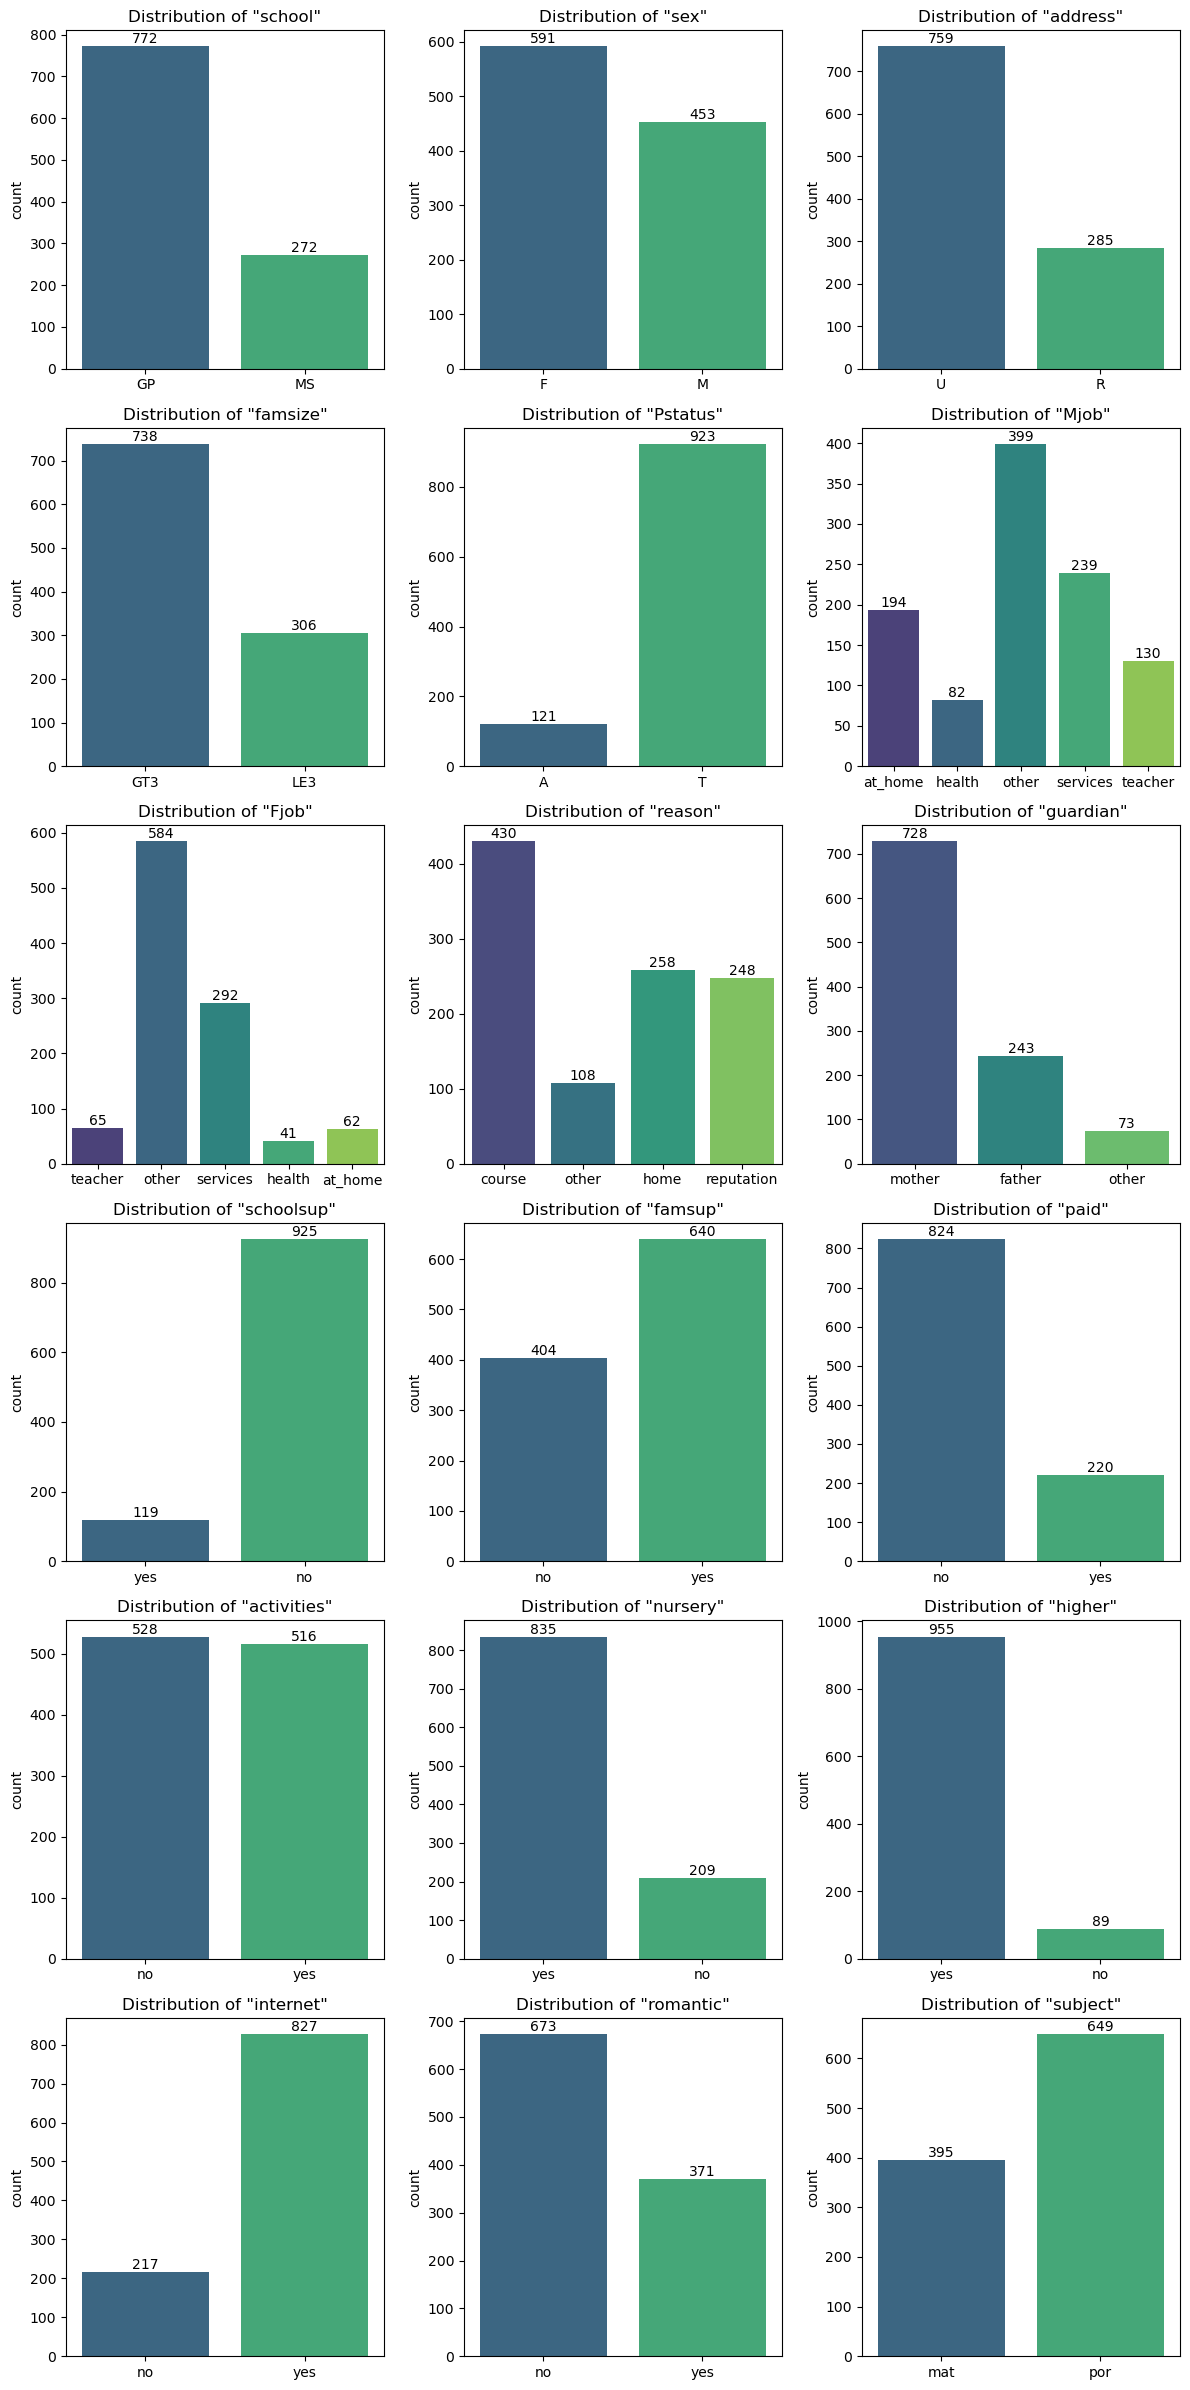

In [9]:
# Visualization cho mỗi cột kiểu category
n_cols = 3
n_rows = math.ceil(len(cat_cols) / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 4 * n_rows))
axes = axes.flatten() # Làm phẳng mảng axes

for i, colname in enumerate(cat_cols):
    sns.countplot(data=df, x=colname, ax=axes[i], palette="viridis", hue=colname)
    
    axes[i].set_title(f'Distribution of \"{colname}\"')
    axes[i].set_xlabel('')

    for container in axes[i].containers:
        axes[i].bar_label(container)

# Tắt các ô trống nếu số biểu đồ không lấp đầy lưới
for i in range(len(cat_cols), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()

**Nhận xét:**
- Một số cột bị mất cân bằng cao (`Pstatus`, `schoolsup`, `higher`): `Pstatus = T` (88%), `schoolsup = no` (88%), `higher = yes` (90%) $\rightarrow$ Những cột này sẽ ít có khả năng phân loại vì không có sự biến thiên mà chỉ thiên về 1 phía. Sẽ gây ra Model bias nếu sử dụng làm `Target`

### Data Quality

In [10]:
missing_vals = df[cat_cols].isnull().sum()
print(f"Missing value in categorical columns:\n{missing_vals}")

Missing value in categorical columns:
school        0
sex           0
address       0
famsize       0
Pstatus       0
Mjob          0
Fjob          0
reason        0
guardian      0
schoolsup     0
famsup        0
paid          0
activities    0
nursery       0
higher        0
internet      0
romantic      0
subject       0
dtype: int64


**Nhận xét:** 
- Không có cột nào có giá trị bị thiếu, giá trị bất thường
- Tuy nhiên, đối với cột `Fjob` ta thấy `health` chỉ chiếm số lượng ít (3.93%) và kích thước mẫu của nhóm khá nhỏ (n = 41) nhưng vẫn đủ ngưỡng tối thiểu để thực hiện các so sánh thống kê

### **Nhận xét chung:** 
- Các cột dữ liệu category: `school`, `sex`, `address`, `famsize`, `Pstatus`, `Mjob`, `Fjob`, `reason`, `guardian`, `schoolsup`, `famsup`, `paid`, `activities`, `nursery`, `higher`, `internet`, `romantic`, `subject`
- Các cột đều bị mất cân bằng dữ liệu (trừ cột `sex`, `activities` khá cân bằng)
- Các cột không có các giá trị bất thường, lỗi hay các giá trị hiếm (trừ `Fjob` nhưng nhóm quyết định giữ giá trị hiếm lại mà không gộp chung)

## Initial Observation and Insights

### Summary
1. Key observation:
- Sự bất thường của Target (`G3`): điểm số có phân phối gần chuẩn nhưng có 53 trường hợp xuất hiện điểm bằng 0.
- Phân phối lệch của `absences`: bị lệch phải nhiều (Skewness = 3.74). Trung vị là 2 nhưng xuất hiện các outlier rất lớn $\rightarrow$ Gây lệch.
- Sự đồng nhất về nhân khẩu học: có sự mất cân bằng lớn trong các biến: 90% có cha mẹ sống chung (`PStatus` = T), đa số có nguyện vọng học cao hơn (`higher` = yes)

2. Data quality issues:
- Imbalanced class: các cột category nhưng đã phân tích ở trên `Pstatus`, `higher`, `Fjob` bị mất cân bằng nghiêm trọng $\rightarrow$ giảm độ tin cậy khi phân tích hành vi của các nhóm này

3. Necessary preprocessing steps:
- Data cleaning:
- Feature Engineering:
- Encoding: sử dụng One-Hot Encoding cho các cột category, vì không có các cột liên quan đến thứ bậc (Ordinal) nên không sử dụng Ordinal Encode

4. Interesting patterns could lead to research questions:
- Những học sinh có số `absences` cao thì sẽ tiêu thụ cồn (`Dalc`/`Walc`) nhiều nhất? 

### Red flags
1. Serious data quality concerns:
2. Limitations might affect analysis: